In [1]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from perlin_numpy import generate_perlin_noise_2d,  generate_fractal_noise_2d 

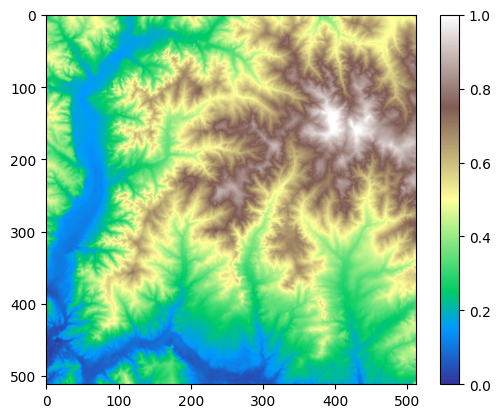

In [67]:
hmap_ = generate_perlin_noise_2d((128, 128), (16,4))
hmap_ = imread('map.png')
#hmap_ = np.invert(hmap_)
hmap_ = hmap_ / 255
hmap = np.copy(hmap_)
plt.imshow(hmap_, cmap='terrain', interpolation='lanczos')
plt.colorbar()

In [111]:
# Inspired by https://nickmcd.me/2020/04/10/simple-particle-based-hydraulic-erosion/

def vec2(x, y=None, dtype=float):
    if y is None:
        return np.array([x, x], dtype)
    return np.array([x, y], dtype)

def vec3(x, y=None, z=None, dtype=float):
    if y is None:
        return np.array([x, x, x], dtype)
    return np.array([x, y, z], dtype)

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

class Particle:
    def __init__(self, pos):
        self.pos = pos
        self.speed = vec2(0)
        self.volume = 1
        self.sediment = 1

class World:
    def __init__(self, heightmap):
        self.heightmap = heightmap
        self.dt = 1.2
        self.min_volume = 0.01
        self.density = 1
        self.friction = 0.05
        self.deposition_rate = 0.1
        self.evaporation_rate = 0.001
        self.scale = 60

    def surface_normal(self, i, j):
        # Adjacent
        n  = vec3(0.15) * normalize(vec3(self.scale*(self.heightmap[i, j]-self.heightmap[i+1, j]), 1, 0))
        n += vec3(0.15) * normalize(vec3(self.scale*(self.heightmap[i-1, j]-self.heightmap[i, j]), 1, 0))
        n += vec3(0.15) * normalize(vec3(0, 1, self.scale*(self.heightmap[i, j]-self.heightmap[i, j+1])))
        n += vec3(0.15) * normalize(vec3(0, 1, self.scale*(self.heightmap[i, j+1]-self.heightmap[i, j])))
        
        # Diagonals
        n += vec3(0.10) * normalize(vec3(self.scale*(self.heightmap[i, j]-self.heightmap[i+1, j+1]) / np.sqrt(2), np.sqrt(2), self.scale*(self.heightmap[i, j]-self.heightmap[i+1, j+1]) / np.sqrt(2)))
        n += vec3(0.10) * normalize(vec3(self.scale*(self.heightmap[i, j]-self.heightmap[i+1, j-1]) / np.sqrt(2), np.sqrt(2), self.scale*(self.heightmap[i, j]-self.heightmap[i+1, j-1]) / np.sqrt(2)))
        n += vec3(0.10) * normalize(vec3(self.scale*(self.heightmap[i, j]-self.heightmap[i-1, j+1]) / np.sqrt(2), np.sqrt(2), self.scale*(self.heightmap[i, j]-self.heightmap[i-1, j+1]) / np.sqrt(2)))
        n += vec3(0.10) * normalize(vec3(self.scale*(self.heightmap[i, j]-self.heightmap[i-1, j-1]) / np.sqrt(2), np.sqrt(2), self.scale*(self.heightmap[i, j]-self.heightmap[i-1, j-1]) / np.sqrt(2)))
        return n

    def erode(self, cycles):
        for i in range(cycles):
            pos = np.random.uniform(self.heightmap.shape[0]-1, size=2)
            drop = Particle(pos)

            while drop.volume > self.min_volume:
                ipos = drop.pos.astype(int)
                n = self.surface_normal(ipos[0], ipos[1]) #vec3
                drop.speed += self.dt * vec2(n[0], n[1]) / (drop.volume * self.density)
                drop.pos   += self.dt * drop.speed
                drop.speed *= (1 - self.dt * self.friction)

                if not np.all(drop.pos > 1) or not np.all(drop.pos < self.heightmap.shape[0]-1):
                    break
                
                max_sediment = drop.volume * np.sqrt(drop.speed.dot(drop.speed)) * (self.heightmap[ipos[0], ipos[1]] - self.heightmap[int(drop.pos[0]), int(drop.pos[1])])
                if max_sediment < 0:
                    max_sediment = 0;
                sdiff = max_sediment - drop.sediment;

                drop.sediment += self.dt * self.deposition_rate * sdiff
                self.heightmap[ipos[0], ipos[1]] -= dt * drop.volume * self.deposition_rate * sdiff

                drop.volume *= (1 - self.dt*self.evaporation_rate)

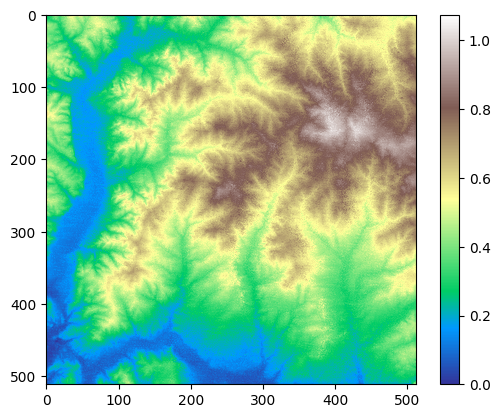

In [114]:
world = World(hmap)

world.erode(20000)


plt.imshow(hmap, cmap='terrain', interpolation='lanczos')
plt.colorbar()

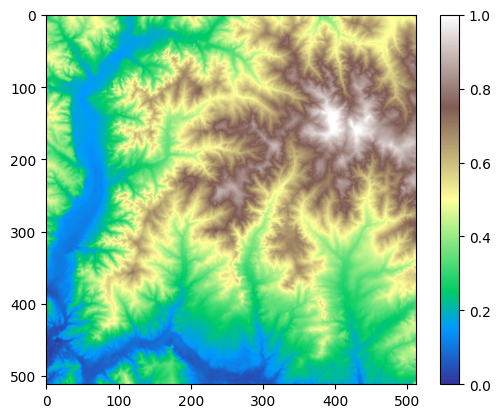

In [115]:
plt.imshow(hmap_, cmap='terrain', interpolation='lanczos')
plt.colorbar()